# MLP - Trading strategy
 - Tensorflow implementation

# Import packages

https://www.kdnuggets.com/2020/08/tensorflow-model-regularization-techniques.html

In [2]:
# Import necesary libraries
import yfinance as yf
import numpy as np
import pandas as pd
from talib import abstract
import matplotlib.pyplot as plt
import talib
import random
import tensorflow as tf
from keras.layers import *
from keras.models import Sequential
from keras.regularizers import l1, l2
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

2023-07-11 14:49:46.462258: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 14:49:46.860297: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 14:49:46.866431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 14:49:48.863967: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Download data


In [3]:
# Download historical data for required stocks
symbol = "EURUSD=X"
df_raw = yf.download(symbol,period='1mo',interval='15m')
df_raw["returns"] = np.log(df_raw.Close.div(df_raw.Close.shift(1)))
df_raw.dropna(how="any",inplace=True)
df_raw["target"] = np.where(df_raw["returns"].shift(-1) > 0, 1, 0)

[*********************100%***********************]  1 of 1 completed


In [4]:
df_raw

,Open,High,Low,Close,Adj Close,Volume,returns,target
Datetime,,,,,,,,
2023-06-12 00:15:00,1.074922,1.075153,1.074922,1.075038,1.075038,0,0.000107,1
2023-06-12 00:30:00,1.075153,1.075269,1.075153,1.075153,1.075153,0,0.000108,1
2023-06-12 00:45:00,1.075153,1.075384,1.075153,1.075269,1.075269,0,0.000108,0
2023-06-12 01:00:00,1.075038,1.075153,1.074807,1.074922,1.074922,0,-0.000323,0
2023-06-12 01:15:00,1.075038,1.075153,1.074807,1.074922,1.074922,0,0.000000,1
...,...,...,...,...,...,...,...,...
2023-07-11 12:45:00,1.099022,1.099143,1.098660,1.098660,1.098660,0,-0.000440,1
2023-07-11 13:00:00,1.098780,1.099264,1.098780,1.099143,1.099143,0,0.000440,0
2023-07-11 13:15:00,1.099143,1.099264,1.098660,1.098780,1.098780,0,-0.000330,0


# Plot the  number of buy and sell trades

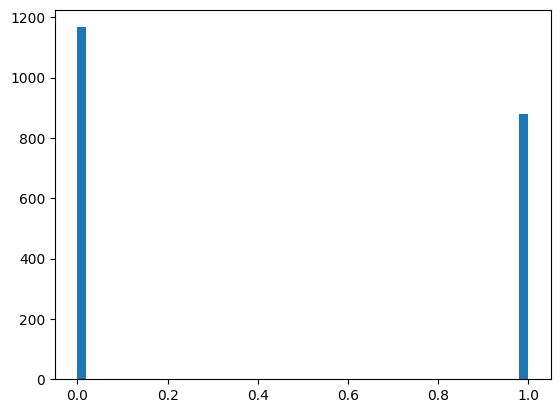

In [5]:
plt.hist(df_raw['target'], bins = 50)
plt.show()

# Apply feature

In [6]:
def get_feature(DF):
  df = DF.copy()

  lags = 200
  nSMAs = 200
  nRSIs = 20
  nADXs = 20

  cols = []

  for lag in range(1, lags + 1):
    col = "lag{}".format(lag)
    df[col] = df["returns"].shift(lag)
    cols.append(col)

  # MACD signals
  df["ma_fast"] = df["Adj Close"].ewm(span=14, min_periods=14).mean()
  cols.append("ma_fast")
  df["ma_slow"] = df["Adj Close"].ewm(span=17, min_periods=17).mean()
  cols.append("ma_slow")
  df["macd"] = df["ma_fast"] - df["ma_slow"]
  cols.append("macd")
  df["signal"] = df["macd"].ewm(span=2, min_periods=17).mean()
  cols.append("signal")

  df['MACD_Signal'] = np.where(df.macd > df.signal, 1, -1)
  cols.append('MACD_Signal')

  # SMA signals
  for nSMA in range(5, nSMAs, 20):
    col1 = "SMA{}".format(nSMA)
    df[col1] = abstract.SMA(df['Close'], timeperiod=nSMA)
    cols.append(col1)
    col2 = "SMA_Signal{}".format(nSMA)
    df[col2] = np.where(df.Close > df[col1], 1, -1)
    cols.append(col2)

  # SMA Crossover signals
  df['fast'] = abstract.SMA(df['returns'], timeperiod=5)
  cols.append('fast')
  df['slow'] = abstract.SMA(df['returns'], timeperiod=8)
  cols.append('slow')
  df['CrossOver_Signal'] = np.where(df.fast > df.slow, 1, -1)
  cols.append('CrossOver_Signal')



  df = df.dropna()

  return df, cols


df, cols = get_feature(df_raw)
df.head()

,Open,High,Low,Close,Adj Close,Volume,returns,target,lag1,lag2,...,SMA_Signal125,SMA145,SMA_Signal145,SMA165,SMA_Signal165,SMA185,SMA_Signal185,fast,slow,CrossOver_Signal
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-06-14 02:15:00,1.079331,1.079447,1.079331,1.079447,1.079447,0,0.000216,1,-0.000108,-0.000108,...,1,1.078299,1,1.078224,1,1.077895,1,0.000086,0.000027,1
2023-06-14 02:30:00,1.079447,1.079797,1.079331,1.079680,1.079680,0,0.000216,0,0.000216,-0.000108,...,1,1.078318,1,1.078235,1,1.077925,1,0.000043,0.000067,-1
2023-06-14 02:45:00,1.079797,1.079797,1.079564,1.079564,1.079564,0,-0.000108,0,0.000216,0.000216,...,1,1.078343,1,1.078243,1,1.077954,1,0.000022,0.000040,-1
2023-06-14 03:00:00,1.079680,1.079680,1.079331,1.079564,1.079564,0,0.000000,1,-0.000108,0.000216,...,1,1.078370,1,1.078253,1,1.077982,1,0.000043,0.000067,-1
2023-06-14 03:15:00,1.079564,1.079914,1.079447,1.079914,1.079914,0,0.000324,0,0.000000,-0.000108,...,1,1.078396,1,1.078265,1,1.078011,1,0.000130,0.000054,1


# Scaling data

In [7]:

ss = StandardScaler() #standardizing the data
X = ss.fit_transform(df[cols])



# Split data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,df.target) #splitting dataset into 2 halves

# Build Model

In [9]:
def set_seeds(seed = 100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1368)              313272    
                                                                 
 dense_1 (Dense)             (None, 2052)              2809188   
                                                                 
 dense_2 (Dense)             (None, 2736)              5617008   
                                                                 
 dense_3 (Dense)             (None, 228)               624036    
                                                                 
 dense_4 (Dense)             (None, 114)               26106     
                                                                 
 dense_5 (Dense)             (None, 76)                8740      
                                                                 
 dense_6 (Dense)             (None, 57)                4

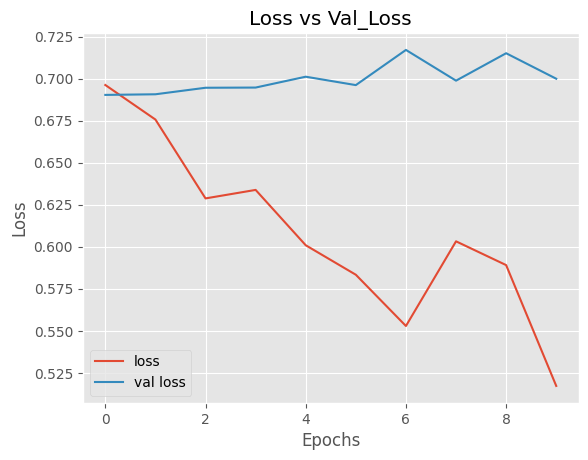

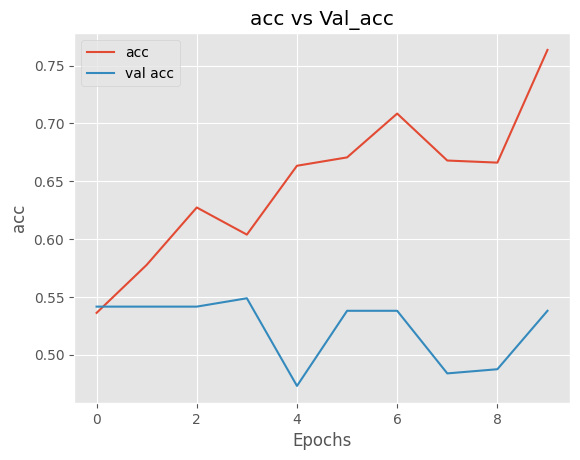

In [10]:

def create_model_1():
    optimizer = Adam(learning_rate=0.001)
    model = Sequential([
      Dense(len(cols) * 6, activation="relu", input_shape=(len(cols),)),

      Dense(len(cols) * 9, activation="relu"),

      Dense(len(cols) * 12, activation="relu"),

      Dense(len(cols), activation="relu"),

      Dense(int(len(cols) / 2), activation="relu"),

      Dense(int(len(cols) / 3), activation="relu"),

      Dense(int(len(cols) / 4), activation="relu"),

      Dense(int(len(cols) / 5), activation="relu"),

      Dense(int(len(cols) / 6), activation="relu"),

      Dense(len(cols), activation="relu"),
    Dense(1)
    ])

    model.add(Dense(1, use_bias=True, activation = "sigmoid"))

    print(model.summary())

    model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['acc', 'mse'])
    return model


set_seeds(100)
model = create_model_1()
model_history = model.fit(x = X_train, y = y_train, epochs = 10, verbose = False, validation_split = 0.2, shuffle = False)
model.evaluate(X_train, y_train ) # evaluate the fit on the train set
loss1, acc1, mse1 = model.evaluate(X_test, y_test)
print(f"Loss is {loss1},\nAccuracy is {acc1*100},\nMSE is {mse1}")

plt.style.use('ggplot')
plt.plot(model_history.history['loss'], label = 'loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


plt.plot(model_history.history['acc'], label = 'acc')
plt.plot(model_history.history['val_acc'], label='val acc')
plt.title("acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_174 (Dense)           (None, 51984)             11904336  
                                                                 
 dense_175 (Dense)           (None, 2052)              106673220 
                                                                 
 dense_176 (Dense)           (None, 2736)              5617008   
                                                                 
 dense_177 (Dense)           (None, 228)               624036    
                                                                 
 dense_178 (Dense)           (None, 228)               52212     
                                                                 
 dense_179 (Dense)           (None, 1)                 229       
                                                                 
 dense_180 (Dense)           (None, 1)               

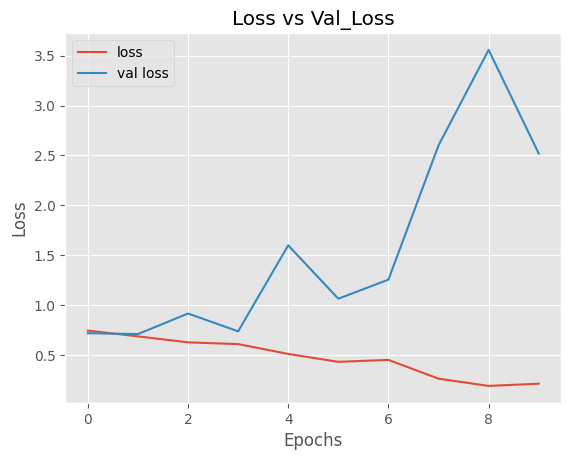

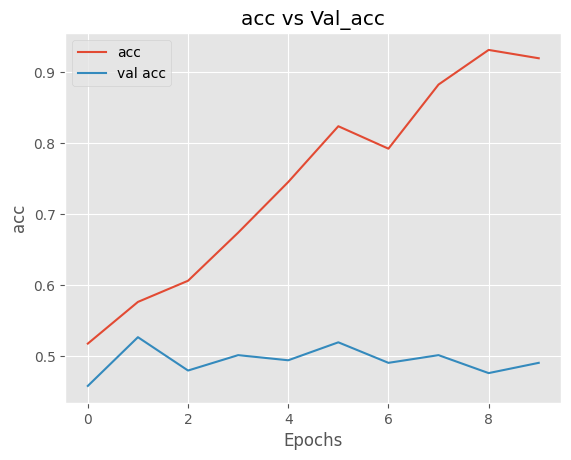

In [27]:

def create_model_1():
    optimizer = Adam(learning_rate=0.001)
    model = Sequential([
      Dense(len(cols) * len(cols), activation="relu", input_shape=(len(cols),)),

      Dense(len(cols) * 9, activation="relu"),

      Dense(len(cols) * 12, activation="relu"),

      Dense(len(cols), activation="relu"),


      Dense(len(cols), activation="relu"),
    Dense(1)
    ])

    model.add(Dense(1, use_bias=True, activation = "sigmoid"))

    print(model.summary())

    model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['acc', 'mse'])
    return model


set_seeds(100)
model = create_model_1()
model_history = model.fit(x = X_train, y = y_train, epochs = 10, verbose = False, validation_split = 0.2, shuffle = False)
loss, acc, mse = model.evaluate(X_train, y_train ) # evaluate the fit on the train set
print(f"Train - Loss is {loss},\nAccuracy is {acc*100},\nMSE is {mse}")



#loss1, acc1, mse1 = model.evaluate(X_test, y_test)
#print(f"Test - Loss is {loss1},\nAccuracy is {acc1*100},\nMSE is {mse1}")

plt.style.use('ggplot')
plt.plot(model_history.history['loss'], label = 'loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


plt.plot(model_history.history['acc'], label = 'acc')
plt.plot(model_history.history['val_acc'], label='val acc')
plt.title("acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

# Neural Network Optimization

## Added an extra parameter kernel_regularizer, which we set it to ‘l1’ for L1 Regularization.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1368)              313272    
                                                                 
 dense_13 (Dense)            (None, 2052)              2809188   
                                                                 
 dense_14 (Dense)            (None, 2736)              5617008   
                                                                 
 dense_15 (Dense)            (None, 228)               624036    
                                                                 
 dense_16 (Dense)            (None, 114)               26106     
                                                                 
 dense_17 (Dense)            (None, 76)                8740      
                                                                 
 dense_18 (Dense)            (None, 57)               

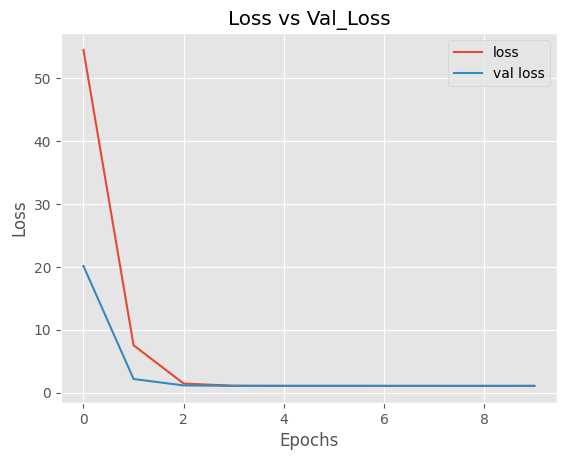

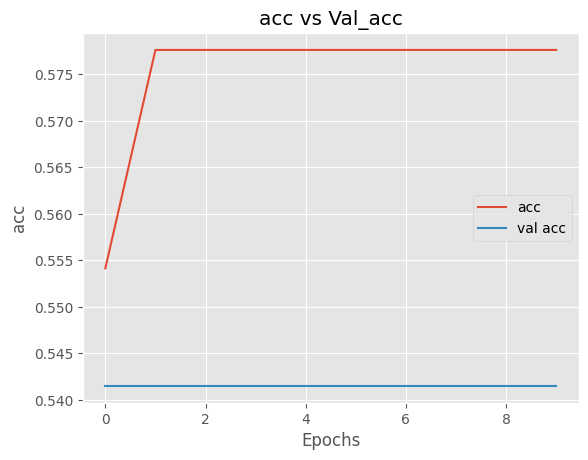

In [11]:

def create_model_2():
    optimizer = Adam(learning_rate=0.001)
    model = Sequential([
      Dense(len(cols) * 6, activation="relu", input_shape=(len(cols),), kernel_regularizer='l1'),

      Dense(len(cols) * 9, activation="relu"),

      Dense(len(cols) * 12, activation="relu"),

      Dense(len(cols), activation="relu"),

      Dense(int(len(cols) / 2), activation="relu"),

      Dense(int(len(cols) / 3), activation="relu"),

      Dense(int(len(cols) / 4), activation="relu"),

      Dense(int(len(cols) / 5), activation="relu"),

      Dense(int(len(cols) / 6), activation="relu"),

      Dense(len(cols), activation="relu"),
    Dense(1)
    ])

    model.add(Dense(1, use_bias=True, activation = "sigmoid"))

    print(model.summary())

    model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['acc', 'mse'])
    return model




set_seeds(100)
model = create_model_2()
model_history = model.fit(x = X_train , y = y_train, epochs = 10, verbose = False, validation_split = 0.2, shuffle = False)
model.evaluate(X_train, y_train) # evaluate the fit on the train set

loss1, acc1, mse1 = model.evaluate(X_test, y_test)
print(f"Loss is {loss1},\nAccuracy is {acc1*100},\nMSE is {mse1}")

plt.style.use('ggplot')
plt.plot(model_history.history['loss'], label = 'loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


plt.plot(model_history.history['acc'], label = 'acc')
plt.plot(model_history.history['val_acc'], label='val acc')
plt.title("acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

## Neural Networks with Feature Selection (Correlation Heatmap/PCA)

## Reduse feature

In [12]:
#df[cols].style.background_gradient(cmap ='viridis').set_properties(**{'font-size': '10px'})

In [13]:
#df[cols].style.background_gradient(cmap ='viridis').set_properties(**{'font-size': '10px'})

In [14]:
df.corr()

,Open,High,Low,Close,Adj Close,Volume,returns,target,lag1,lag2,...,SMA_Signal125,SMA145,SMA_Signal145,SMA165,SMA_Signal165,SMA185,SMA_Signal185,fast,slow,CrossOver_Signal
Open,1.000000,0.997939,0.998101,0.996043,0.996043,NaN,-0.044335,-0.038396,0.035533,0.040809,...,0.319514,0.718433,0.289863,0.674805,0.290595,0.632812,0.301198,0.047533,0.084328,-0.021010
High,0.997939,1.000000,0.997147,0.998145,0.998145,NaN,-0.002141,-0.036596,0.037871,0.039131,...,0.329813,0.715108,0.298195,0.671461,0.297727,0.629479,0.308066,0.067115,0.099544,-0.012893
Low,0.998101,0.997147,1.000000,0.998078,0.998078,NaN,-0.001992,-0.040771,0.039623,0.040594,...,0.322596,0.716620,0.292662,0.672964,0.293568,0.631067,0.303975,0.067183,0.100151,-0.013151
Close,0.996043,0.998145,0.998078,1.000000,1.000000,NaN,0.036324,-0.039797,0.041574,0.042120,...,0.332873,0.712463,0.301028,0.668808,0.300503,0.626951,0.311232,0.086698,0.116996,-0.007210
Adj Close,0.996043,0.998145,0.998078,1.000000,1.000000,NaN,0.036324,-0.039797,0.041574,0.042120,...,0.332873,0.712463,0.301028,0.668808,0.300503,0.626951,0.311232,0.086698,0.116996,-0.007210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMA185,0.632812,0.629479,0.631067,0.626951,0.626951,NaN,-0.075313,-0.046212,-0.073525,-0.071996,...,-0.307552,0.980932,-0.361372,0.995169,-0.372527,1.000000,-0.366013,-0.159514,-0.191463,0.011841
SMA_Signal185,0.301198,0.308066,0.303975,0.311232,0.311232,NaN,0.112125,-0.006539,0.086812,0.101664,...,0.796341,-0.259516,0.871040,-0.318124,0.936998,-0.366013,1.000000,0.212895,0.261133,-0.015483
fast,0.047533,0.067115,0.067183,0.086698,0.086698,NaN,0.455093,0.028303,0.450563,0.472324,...,0.266568,-0.159629,0.247680,-0.161891,0.218684,-0.159514,0.212895,1.000000,0.801621,0.406699
slow,0.084328,0.099544,0.100151,0.116996,0.116996,NaN,0.382387,0.033876,0.380155,0.377097,...,0.322634,-0.190171,0.290999,-0.193755,0.264865,-0.191463,0.261133,0.801621,1.000000,0.005477


## Neural Networks with Regularization (DropOut and L1/L2)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_155 (Dense)           (None, 1368)              313272    
                                                                 
 dense_156 (Dense)           (None, 2052)              2809188   
                                                                 
 dense_157 (Dense)           (None, 2736)              5617008   
                                                                 
 dense_158 (Dense)           (None, 228)               624036    
                                                                 
 dense_159 (Dense)           (None, 114)               26106     
                                                                 
 dense_160 (Dense)           (None, 76)                8740      
                                                                 
 dense_161 (Dense)           (None, 57)              

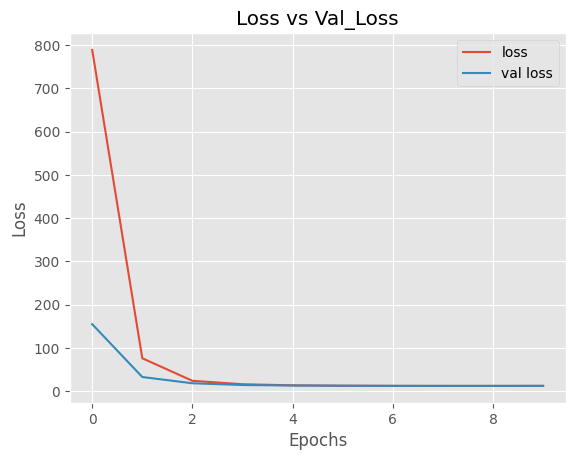

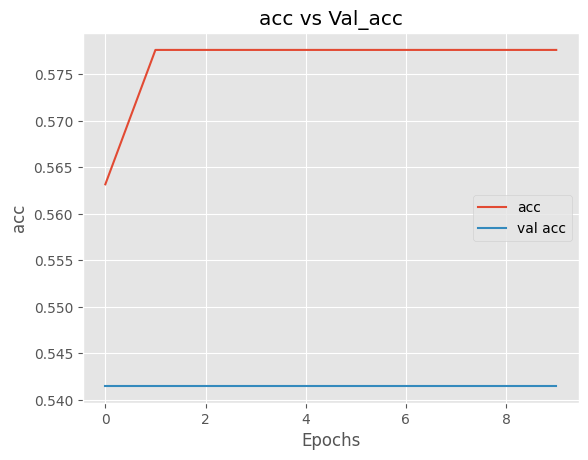

In [25]:

def create_model_2():
    optimizer = Adam(learning_rate=0.001)
    model = Sequential([
      Dense(len(cols) * 6, activation="relu", input_shape=(len(cols),), kernel_regularizer='l1'),

      Dense(len(cols) * 9, activation="relu", kernel_regularizer='l1'),

      Dense(len(cols) * 12, activation="relu", kernel_regularizer='l1'),

      Dense(len(cols), activation="relu", kernel_regularizer='l1'),

      Dense(int(len(cols) / 2), activation="relu", kernel_regularizer='l1'),

      Dense(int(len(cols) / 3), activation="relu", kernel_regularizer='l1'),

      Dense(int(len(cols) / 4), activation="relu", kernel_regularizer='l1'),

      Dense(int(len(cols) / 5), activation="relu", kernel_regularizer='l1'),

      Dense(int(len(cols) / 6), activation="relu", kernel_regularizer='l1'),

      Dense(len(cols), activation="relu", kernel_regularizer='l1'),
    Dense(1)
    ])

    model.add(Dense(1, use_bias=True, activation = "sigmoid"))

    print(model.summary())

    model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['acc', 'mse'])
    return model


set_seeds(100)
model = create_model_2()
model_history = model.fit(x = X_train, y = y_train, epochs = 10, verbose = False, validation_split = 0.2, shuffle = False)
model.evaluate(X_train, y_train ) # evaluate the fit on the train set

loss1, acc1, mse1 = model.evaluate(X_test, y_test)
print(f"Loss is {loss1},\nAccuracy is {acc1*100},\nMSE is {mse1}")


plt.style.use('ggplot')
plt.plot(model_history.history['loss'], label = 'loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


plt.plot(model_history.history['acc'], label = 'acc')
plt.plot(model_history.history['val_acc'], label='val acc')
plt.title("acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.legend()
plt.show()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_114 (Dense)           (None, 228)               52212     
                                                                 
 dense_115 (Dense)           (None, 228)               52212     
                                                                 
 dense_116 (Dense)           (None, 228)               52212     
                                                                 
 dense_117 (Dense)           (None, 228)               52212     
                                                                 
 dense_118 (Dense)           (None, 228)               52212     
                                                                 
 dense_119 (Dense)           (None, 228)               52212     
                                                                 
 dense_120 (Dense)           (None, 228)              

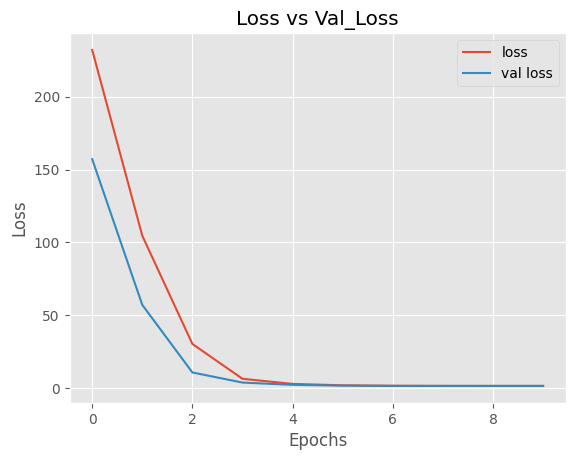

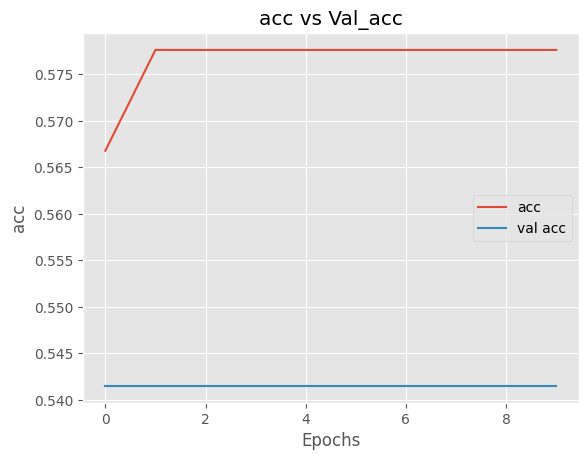

In [22]:

def create_model_2():
    optimizer = Adam(learning_rate=0.001)
    model = Sequential([
      Dense(len(cols), activation="relu", input_shape=(len(cols),), kernel_regularizer='l1'),
      Dense(len(cols), activation="relu", kernel_regularizer='l1'),
      Dense(len(cols), activation="relu", kernel_regularizer='l1'),
      Dense(len(cols), activation="relu", kernel_regularizer='l1'),
      Dense(len(cols), activation="relu", kernel_regularizer='l1'),
      Dense(len(cols), activation="relu", kernel_regularizer='l1'),
      Dense(len(cols), activation="relu", kernel_regularizer='l1'),
      Dense(len(cols), activation="relu", kernel_regularizer='l1'),
      Dense(len(cols), activation="relu", kernel_regularizer='l1'),
      Dense(int(len(cols) / 2), activation="relu", kernel_regularizer='l1'),
      Dense(int(len(cols) / 3), activation="relu", kernel_regularizer='l1'),
      Dense(int(len(cols) / 4), activation="relu", kernel_regularizer='l1'),
      Dense(int(len(cols) / 5), activation="relu", kernel_regularizer='l1'),
      Dense(int(len(cols) / 6), activation="relu", kernel_regularizer='l1'),
      Dense(len(cols), activation="relu", kernel_regularizer='l1'),
    Dense(1)
    ])

    model.add(Dense(1, use_bias=True, activation = "sigmoid"))

    print(model.summary())

    model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['acc', 'mse'])
    return model


set_seeds(100)
model = create_model_2()
model_history = model.fit(x = X_train, y = y_train, epochs = 10, verbose = False, validation_split = 0.2, shuffle = False)
model.evaluate(X_train, y_train ) # evaluate the fit on the train set
loss1, acc1, mse1 = model.evaluate(X_test, y_test)
print(f"Loss is {loss1},\nAccuracy is {acc1*100},\nMSE is {mse1}")

plt.style.use('ggplot')
plt.plot(model_history.history['loss'], label = 'loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


plt.plot(model_history.history['acc'], label = 'acc')
plt.plot(model_history.history['val_acc'], label='val acc')
plt.title("acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

In [ ]:

def create_model_2():
    optimizer = Adam(learning_rate=0.001)
    model = Sequential([
      Dense(len(cols), activation="relu", input_shape=(len(cols),), kernel_regularizer='l1'),
      Dense(len(cols), activation="relu", kernel_regularizer='l1'),
      Dense(len(cols), activation="relu", kernel_regularizer='l1'),
      Dense(len(cols), activation="relu", kernel_regularizer='l1'),
      Dense(len(cols), activation="relu", kernel_regularizer='l1'),
      Dense(len(cols), activation="relu", kernel_regularizer='l1'),
      Dense(len(cols), activation="relu", kernel_regularizer='l1'),
      Dense(len(cols), activation="relu", kernel_regularizer='l1'),
      Dense(len(cols), activation="relu", kernel_regularizer='l1'),
      Dense(int(len(cols) / 2), activation="relu", kernel_regularizer='l1'),
      Dense(int(len(cols) / 3), activation="relu", kernel_regularizer='l1'),
      Dense(int(len(cols) / 4), activation="relu", kernel_regularizer='l1'),
      Dense(int(len(cols) / 5), activation="relu", kernel_regularizer='l1'),
      Dense(int(len(cols) / 6), activation="relu", kernel_regularizer='l1'),
      Dense(len(cols), activation="relu", kernel_regularizer='l1'),
    Dense(1)
    ])

    model.add(Dense(1, use_bias=True, activation = "sigmoid"))

    print(model.summary())

    model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['acc', 'mse'])
    return model


set_seeds(100)
model = create_model_2()
model_history = model.fit(x = X_train, y = y_train, epochs = 10, verbose = False, validation_split = 0.2, shuffle = False)
model.evaluate(X_train, y_train ) # evaluate the fit on the train set
loss1, acc1, mse1 = model.evaluate(X_test, y_test)
print(f"Loss is {loss1},\nAccuracy is {acc1*100},\nMSE is {mse1}")

plt.style.use('ggplot')
plt.plot(model_history.history['loss'], label = 'loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


plt.plot(model_history.history['acc'], label = 'acc')
plt.plot(model_history.history['val_acc'], label='val acc')
plt.title("acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

## Neural Networks with additional layers (increase model complexity)

## Neural Networks with different optimizers

## Neural Networks with higher epochs (Early Stopping)

## Neural Networks with different activation and initializer

## Neural Networks with smaller batch size